In [2]:
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances

import numpy as np
from typing import Union
import math

sys.path.append('..')
from lib.model_utils import ModelUtil, export_rules_to_csv
utils = ModelUtil(data_name = 'german', model_name = 'random forest')

Test
Accuracy Score is 0.828
Precision Score is 0.8663101604278075
F1 Score is 0.88283378746594
Train
Accuracy Score is 0.8932692307692308


In [3]:
mat = utils.get_cover_matrix(utils.X, fuzzy = True)

In [4]:
new_mat = (mat < 1) * 0.5 * mat + (mat == 1) * mat

In [14]:
mat0 = utils.get_cover_matrix(utils.X, fuzzy = False)

In [4]:
class LOCIMatrix():
    """
    data: np.ndarray
    alpha: float, optional
    k: int, optional
    See the loci function for more details on the parameters.
    Attributes
    ----------
    _data: np.ndarray
    _alpha: float
    _k: int
    max_dist: float
    n_points: int
    indice: np.ndarray
    _dist_matrix: np.ndarray
        The distance matrix, has shape [n_data_points, n_data_points]
    """

    def __init__(self, data: np.ndarray, alpha: float = 0.5, metric = 'euclidean'):
        self.data = data
        self.alpha = alpha

        self.max_dist = None
        self.n_points = self.data.shape[0]
        self.indice = None
        self.dist_matrix = pairwise_distances(X = self.data, metric=metric)
        self.sorted_neighbors = np.argsort(self.dist_matrix, axis=1)
        self.sorted_dist = np.sort(self.dist_matrix, axis=1)
        self.outer_ptr = np.zeros(self.n_points).astype(int)
        self.inner_ptr = np.zeros(self.n_points).astype(int)

    def update_outer_pointer(self, r):
        ptr = self.outer_ptr
        for i in range(self.n_points):
            while ptr[i] < self.n_points and self.sorted_dist[i, ptr[i]] <= r:
                ptr[i] += 1

    def update_inner_pointer(self, r):
        ptr = self.inner_ptr
        for i in range(self.n_points):
            while ptr[i] < self.n_points and self.sorted_dist[i, ptr[i]] <= r:
                ptr[i] += 1

    def run(self):
        """Executes the LOCI algorithm"""
        self.result = []
        for p_ix in range(self.n_points):
            self.result.append({
                'records': [],
            })
        sqrt_n = int(math.sqrt(self.n_points))
        r_max = self.sorted_dist[:, sqrt_n].max() / self.alpha
        r_min = self.sorted_dist[:, 10].min()
        self.rs = []
        self.scores = [[] for _ in range(self.n_points)]
        print('r range: %.3f - %.3f, alpha: %.3f' % (r_min, r_max, self.alpha))

        n_steps = 250
        for i in range(n_steps):
            r = i / n_steps * (r_max - r_min) + r_min
            self.rs.append(r)
            self.update_outer_pointer(r)
            self.update_inner_pointer(self.alpha * r)
            for p_ix in range(self.n_points):
                neighbors = self._get_sampling_N(p_ix)
                n_values = self._get_alpha_n(neighbors)
                cur_alpha_n = self._get_alpha_n(p_ix)

                n_hat = np.mean(n_values)
                mdef = 1 - (cur_alpha_n / n_hat)
                sigma_mdef = np.std(n_values) / n_hat
                self.result[p_ix]['records'].append((r, mdef, sigma_mdef))

                score = 0
                if len(neighbors) >= 20:
                    if sigma_mdef > 0:
                        score = mdef / sigma_mdef
                self.scores[p_ix].append(score)

        step = (r_max - r_min) / n_steps
        r = self.sorted_dist[:, int(math.sqrt(self.n_points))].mean()
        self.indice = np.array([int((self.sorted_dist[i, sqrt_n] - r_min) / step) for i in range(self.n_points)])
        self.min_indice = np.array([np.argmin(self.scores[i]) for i in range(self.n_points)])
        self.max_indice = np.array([np.argmax(self.scores[i]) for i in range(self.n_points)])
        self.scores = np.array(self.scores)
        self.outlier_score = np.array([self.scores[i, self.indice[i]] for i in range(self.n_points)])
        return True

    def label_propagation(self, x, label, thres = 0.10):
        conf = {}
        visit = {}
        conf[x] = 1
        Q = [x]
        head = 0
        while head < len(Q):
            x = Q[head]
            head += 1
            if x in visit:
                continue
            visit[x] = 1
            
            if label == 0:
                new_indice = self.min_indice[x]
            else:
                new_indice = self.max_indice[x]
            self.indice[x] = self.indice[x] * conf[x] + new_indice * (1 - conf[x])
            for i, j in enumerate(self.sorted_neighbors[x]):
                sim = (1 - self.sorted_dist[x, i]) * conf[x]
                if sim < thres:
                    break
                conf[j] = conf.get(j, 0) + sim
                Q.append(j)

    def _get_sampling_N(self, p_ix: int):
        return self.sorted_neighbors[p_ix][:self.outer_ptr[p_ix]]

    def _get_alpha_n(self, indices: Union[int, np.ndarray]):
        return self.inner_ptr[indices]



In [9]:
res = LOCIMatrix(new_mat, alpha = 0.8, metric = 'cosine')
res.run()

r range: 0.211 - 1.073, alpha: 0.800


True

In [10]:
res0 = LOCIMatrix(mat0, alpha = 0.8, metric = 'cosine')
res0.run()

r range: 0.250 - 1.080, alpha: 0.800


True

In [12]:
rese = LOCIMatrix(new_mat, alpha = 0.5, metric = 'euclidean')
rese.run()

r range: 1.414 - 29.319, alpha: 0.500


True

In [15]:
rese0 = LOCIMatrix(mat0, alpha = 0.5, metric = 'euclidean')
rese0.run()

r range: 1.414 - 26.153, alpha: 0.500


True

In [41]:
rese5 = LOCIMatrix(mat, alpha = 0.5, metric = 'euclidean')
rese5.run()
rese6 = LOCIMatrix(mat, alpha = 0.6, metric = 'euclidean')
rese6.run()
rese7 = LOCIMatrix(mat, alpha = 0.7, metric = 'euclidean')
rese7.run()
rese8 = LOCIMatrix(mat, alpha = 0.8, metric = 'euclidean')
rese8.run()
rese9 = LOCIMatrix(mat, alpha = 0.9, metric = 'euclidean')
rese9.run()

r range: 1.414 - 29.881, alpha: 0.500
r range: 1.414 - 24.900, alpha: 0.600
r range: 1.414 - 21.343, alpha: 0.700
r range: 1.414 - 18.675, alpha: 0.800
r range: 1.414 - 16.600, alpha: 0.900


True

In [5]:
rese5 = LOCIMatrix(mat, alpha = 0.5, metric = 'euclidean')
rese5.run()

r range: 1.414 - 29.881, alpha: 0.500


True

In [77]:
rese5n = LOCIMatrix(new_mat, alpha = 0.5, metric = 'euclidean')
rese5n.run()

r range: 1.414 - 29.319, alpha: 0.500


True

In [27]:
from sklearn.manifold import TSNE
x_tsne = TSNE(n_components=2, metric='precomputed').fit_transform(res.dist_matrix)

/home/lizhen/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lizhen/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/lizhen/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


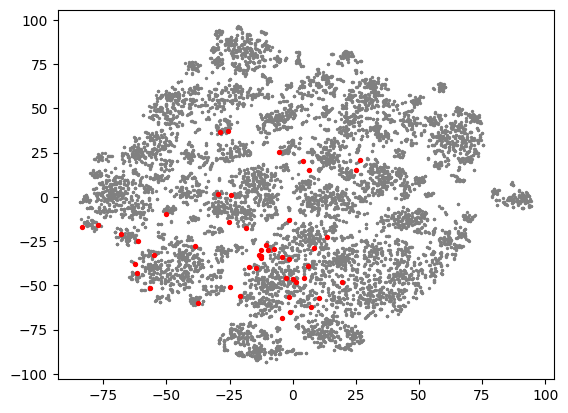

In [136]:
anomaly = res_e.outlier_score.argsort()[-50:][::-1]
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], s = 2, color='gray')
plt.scatter(x_tsne[anomaly, 0], x_tsne[anomaly, 1], s = 8, color='red')
plt.show()

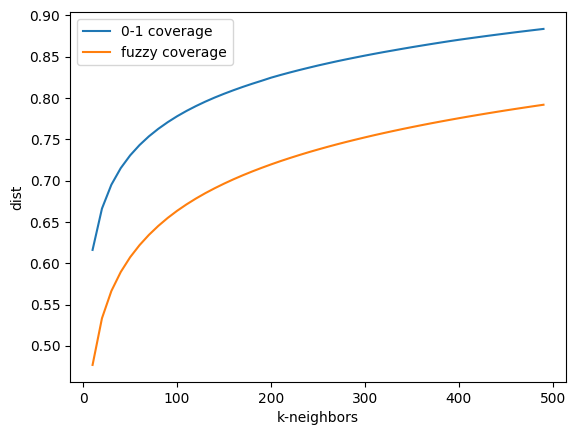

In [35]:
fig, ax = plt.subplots()
xs = [i for i in range(10, 500, 10)]
ax.plot(xs, res0.sorted_dist[:, xs].mean(axis = 0), label='0-1 coverage')
ax.plot(xs, res.sorted_dist[:, xs].mean(axis = 0), label='fuzzy coverage')
ax.set_xlabel('k-neighbors')
ax.set_ylabel('dist')
ax.legend()
plt.show()

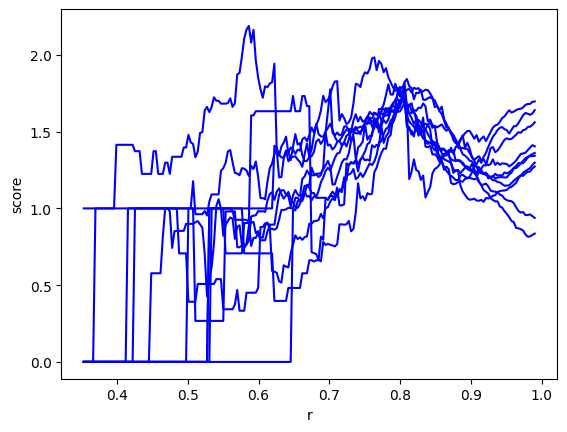

In [140]:
fig, ax = plt.subplots()
tp = res.outlier_score.argsort()[-10:]
for x in tp:
    ranks = []
    xs = [y[0] for y in res.result[x]['records'][50:-5]]
    mdefs = np.array([y[1] for y in res.result[x]['records'][50:-5]])
    s_mdefs = np.array([max(y[2], 0.01) for y in res.result[x]['records'][50:-5]])
    ax.plot(xs, mdefs / s_mdefs, label=str(x) + ' score', color='b')
ax.set_xlabel('r')
ax.set_ylabel('score')
# ax.set_yscale('log')
#  ax.legend()
plt.show()

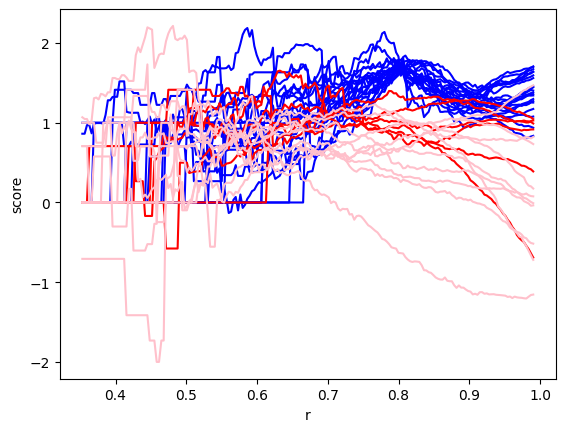

In [135]:
fig, ax = plt.subplots()
tp = res.outlier_score.argsort()[-20:]
for x in tp:
    ranks = []
    xs = [y[0] for y in res.result[x]['records'][50:-5]]
    mdefs = np.array([y[1] for y in res.result[x]['records'][50:-5]])
    s_mdefs = np.array([max(y[2], 0.01) for y in res.result[x]['records'][50:-5]])
    ax.plot(xs, mdefs / s_mdefs, label=str(x) + ' score', color='b')
fp = [8629, 1193, 2732, 5578, 4628, 4234]
for x in fp:
    ranks = []
    xs = [y[0] for y in res.result[x]['records'][50:-5]]
    mdefs = np.array([y[1] for y in res.result[x]['records'][50:-5]])
    s_mdefs = np.array([max(y[2], 0.01) for y in res.result[x]['records'][50:-5]])
    ax.plot(xs, mdefs / s_mdefs, label=str(x) + ' score', color='r')
normal = [1,2,3,4,5,6,7,8,9,50]
for x in normal:
    ranks = []
    xs = [y[0] for y in res.result[x]['records'][50:-5]]
    mdefs = np.array([y[1] for y in res.result[x]['records'][50:-5]])
    s_mdefs = np.array([max(y[2], 0.01) for y in res.result[x]['records'][50:-5]])
    ax.plot(xs, mdefs / s_mdefs, label=str(x) + ' score', color='pink')
ax.set_xlabel('r')
ax.set_ylabel('score')
# ax.set_yscale('log')
#  ax.legend()
plt.show()

In [16]:
all_labels = {7305: 1, 8624: 0, 1884: 1, 468: 1, 6290: 0, 8055: 0, 2280: 1, 3400: 1, 4466: 0, 4650: 0, 6028: 1, 4459: 1, 1411: 1, 665: 0, 868: 1, 8911: 1, 3848: 0, 9283: 0, 5218: 0, 3035: 0, 1010: 1, 8934: 1, 6483: 1, 2807: 1, 5767: 1, 1763: 1, 4479: 1, 679: 1, 873: 1, 6641: 1, 178: 0, 2278: 1, 7567: 0, 287: 1, 7527: 1, 6569: 1, 3487: 1, 2363: 1, 1750: 0, 2300: 1, 6277: 0, 8240: 1, 7499: 1, 525: 0, 4785: 0, 9324: 0, 3337: 1, 3617: 1, 5003: 1, 2089: 1, 3204: 1, 991: 1, 2167: 1, 3488: 1, 1507: 1, 1840: 1, 4932: 1, 254: 1, 9096: 1, 5974: 0, 7529: 1, 2764: 1, 9134: 1, 2112: 0, 7845: 0, 8073: 1, 4657: 0, 3270: 1, 5502: 1, 616: 1, 6787: 0, 6801: 1, 3486: 1, 405: 1, 3485: 1, 8092: 1, 1393: 0, 668: 1, 8389: 0, 2277: 1, 8629: 0, 1520: 1, 4104: 1, 712: 0, 6952: 1, 1330: 1, 8415: 1, 6471: 1, 690: 1, 5575: 1, 5590: 0, 5252: 0, 2079: 1, 1940: 0, 3891: 1, 2916: 0, 1939: 1, 6839: 0, 4384: 1, 3628: 1, 2664: 1, 8645: 1, 7572: 1, 736: 0, 2228: 1, 4759: 1, 729: 0, 4980: 1, 2009: 1, 2099: 0, 4995: 0, 7810: 1, 7571: 1, 5459: 1, 2817: 1, 4812: 1, 4983: 0, 6289: 0, 8022: 0, 4647: 1, 3618: 1, 9452: 1, 4978: 1, 4350: 1, 2706: 1, 758: 1, 2500: 0, 1017: 0, 7915: 0, 5237: 1, 1963: 1, 7556: 0, 3451: 1, 4977: 1, 7456: 1, 424: 1, 4867: 1, 2279: 1, 4234: 0, 3313: 1, 1703: 1, 9289: 0, 827: 0, 8258: 1}


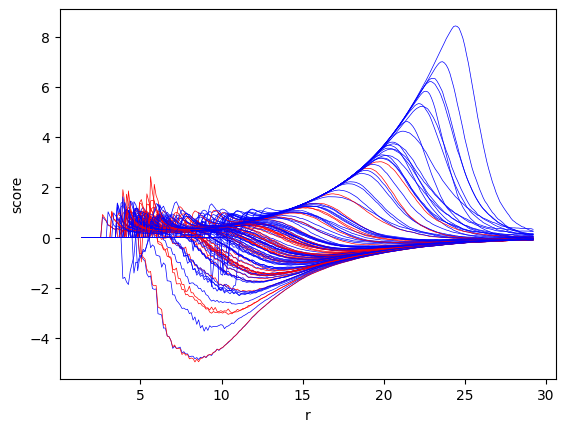

In [72]:
fig, ax = plt.subplots()
fp = [i for i in all_labels if all_labels[i] == 0]
tp = [i for i in all_labels if all_labels[i] == 1]
lines = []

xs = rese5.rs[:-5]
for x in fp:
    lines.append((rese5.scores[x, :-5], 'r', x))
for x in tp:
    lines.append((rese5.scores[x, :-5], 'b', x))

import random
random.shuffle(lines)
for (ys, color, index) in lines:
    ax.plot(xs, ys, color=color, linewidth=0.5)
ax.set_xlabel('r')
ax.set_ylabel('score')
plt.show()

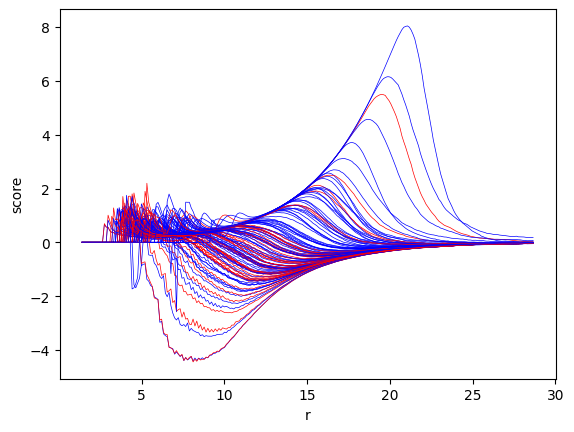

In [37]:
fig, ax = plt.subplots()
fp = [i for i in all_labels if all_labels[i] == 0]
tp = [i for i in all_labels if all_labels[i] == 1]
lines = []

xs = rese.rs[:-5]
for x in fp:
    lines.append((rese.scores[x, :-5], 'r', x))
for x in tp:
    lines.append((rese.scores[x, :-5], 'b', x))

import random
random.shuffle(lines)
for (ys, color, index) in lines:
    ax.plot(xs, ys, color=color, linewidth=0.5)
ax.set_xlabel('r')
ax.set_ylabel('score')
plt.show()

In [142]:
max_count = 0
for k in range(50, len(xs)):
    count = 0
    for i in np.argsort([x[0][k] for x in lines])[-50:][::-1]:
        count += all_labels[lines[i][2]]
    if count > max_count:
        max_count = count
        print(xs[k], max_count)

4.451435149515193 33
4.512179581258034 35
4.572924013000876 37
8.642800939771288 39
8.946523098485498 40
9.189500825456866 41
9.61471184765676 42
13.745333206170013 43
16.175110475883688 44


In [116]:
res_e.rs[135]

16.78605073482887

11.524325532173943

In [94]:
rese5.scores[idxes, 60].argsort()[:3]

array([162, 160, 122])

In [96]:
rese5.scores[162, :]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

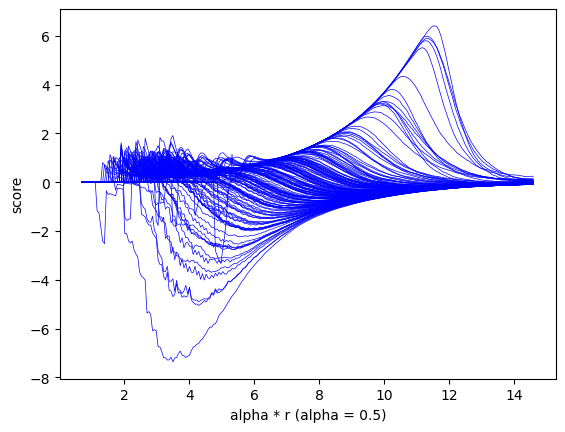

In [6]:
fig, ax = plt.subplots()
lines = []

xs = np.array(rese5.rs[:-5]) * 0.5
idxes =  range(2, 9000, 45)
for x in idxes:
    lines.append((rese5.scores[x, :-5], 'b', x))

import random
random.shuffle(lines)
for (ys, color, index) in lines:
    ax.plot(xs, ys, color=color, linewidth=0.5)
ax.set_xlabel('alpha * r (alpha = 0.5)')
ax.set_ylabel('score')
plt.show()

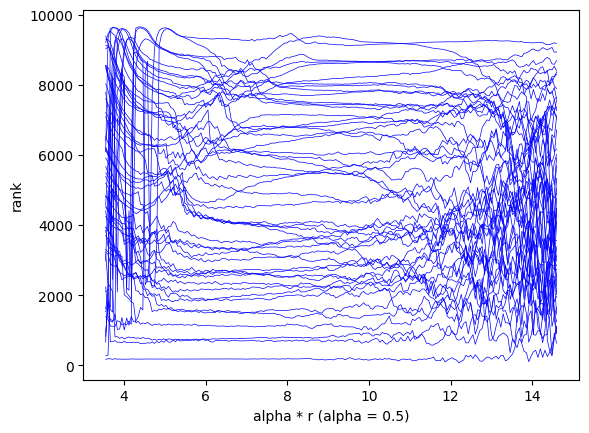

In [11]:
fig, ax = plt.subplots()
lines = []

ranks = np.zeros(rese5.scores.shape)
for i in range(ranks.shape[1]):
    ranks[rese5.scores[:, i].argsort(), i] = range(ranks.shape[0])

xs = np.array(rese5.rs[50:-5]) * 0.5
idxes =  range(2, 9000, 180)
for x in idxes:
    lines.append((ranks[x, 50:-5], 'b', x))

import random
random.shuffle(lines)
for (ys, color, index) in lines:
    ax.plot(xs, ys, color=color, linewidth=0.5)
ax.set_xlabel('alpha * r (alpha = 0.5)')
ax.set_ylabel('rank')
plt.show()

In [92]:
for i in rese5.scores[idxes, 60].argsort()[:3]:
    print(rese5.scores[i, 60], utils.interpret_path(utils.paths[i]))

0.0 ([('savings', 'is', 'unknown/no savings account or < 100 DM'), ('property', 'is not', 'real estate'), ('purpose', 'is not', 'others'), ('status', 'is not', 'no checking account and ... < 0 DM'), ('amount', '<=', 7973), ('housing', 'is not', 'for free'), ('credit_history', 'is not', 'all credits at this bank paid back duly'), ('present_residence', 'is not', '< 1 yr and 1 to 4 yrs')], 'accept')
0.3128400822663389 ([('savings', 'is', 'unknown/no savings account or < 100 DM'), ('property', 'is not', 'real estate'), ('purpose', 'is not', 'others'), ('status', 'is not', 'no checking account and ... < 0 DM'), ('amount', '<=', 7973), ('housing', 'is not', 'for free'), ('credit_history', 'is not', 'all credits at this bank paid back duly'), ('present_residence', 'is not', '4 to 7 yrs and >= 7 yrs'), ('personal_status_sex', 'is', 'married male'), ('installment_rate', 'is not', '>= 35')], 'accept')
0.3016622917019974 ([('status', 'is not', '... >= 200 DM (salary)'), ('duration', '>=', 7), ('p

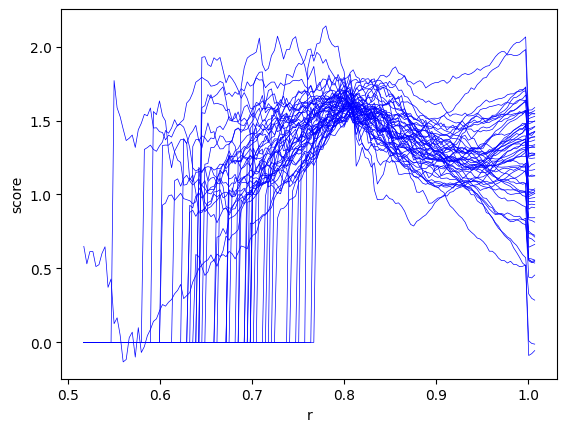

In [62]:

res.outlier_score = res.scores[:, 188]
fig, ax = plt.subplots()
tp = res.outlier_score.argsort()[-50:]
for x in tp:
    ranks = []
    ax.plot(res.rs[100:], res.scores[x, 100:], linewidth=0.5, color='b')
ax.set_xlabel('r')
ax.set_ylabel('score')
plt.show()

In [146]:
export_rules_to_csv('loci_euclidean_r_alpha_0.9', utils, res_e.scores[:, 240].argsort()[-50:][::-1])

In [38]:
o_idxes = [668, 8019, 6515, 2009, 8020, 2819, 7878, 4381, 8235, 6455]
print('hole', res.sorted_dist[o_idxes, 100].mean(), res.sorted_dist[:, 100].mean())
print('all', res0.sorted_dist[o_idxes, 100].mean(), res0.sorted_dist[:, 100].mean())

hole 0.675872945042011 0.6967762154769981


NameError: name 'res0' is not defined

In [22]:
rese0.sorted_dist.mean()

6.2511275002461035

In [39]:
o_idxes = [668, 8019, 6515, 2009, 8020, 2819, 7878, 4381, 8235, 6455]
print('new', rese.sorted_dist[o_idxes, 1000].mean(), rese.sorted_dist[:, 1000].mean())
print('old', rese0.sorted_dist[o_idxes, 1000].mean(), rese0.sorted_dist[:, 1000].mean())

new 6.501197095581192 6.208358090697794
old 4.726930308092262 5.336368427249221


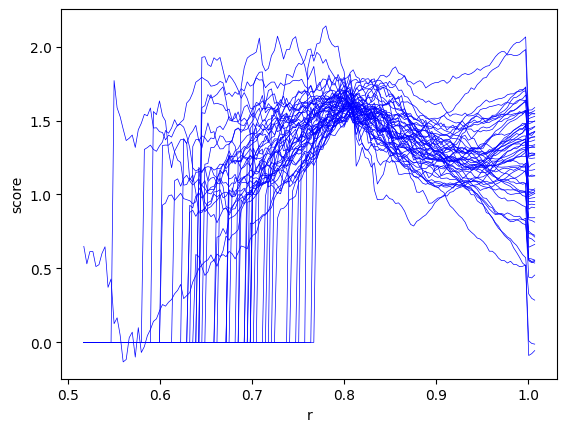

In [ ]:

res.outlier_score = res.scores[:, 188]
fig, ax = plt.subplots()
tp = res.outlier_score.argsort()[-50:]
for x in tp:
    ranks = []
    ax.plot(res.rs[100:], res.scores[x, 100:], linewidth=0.5, color='b')
ax.set_xlabel('r')
ax.set_ylabel('score')
plt.show()

In [154]:
res.sorted_dist[:, 20].mean() / res.sorted_dist[:, 100].mean()

0.8039245235268431

In [155]:
res0.sorted_dist[:, 20].mean() / res0.sorted_dist[:, 100].mean()

0.8563419496867082

In [80]:
export_rules_to_csv('euclidean_alphar12_top50', utils, rese9.scores[:, 175].argsort()[-50:][::-1])

In [186]:
res_e.scores[res_e.scores[:, 175].argsort()[-10:][::-1], 175]

array([31.43627015, 28.56642752, 27.85932388, 25.74745237, 25.74320701,
       21.92742162, 21.51329301, 21.074741  , 19.55989744, 18.99753554])

In [184]:
np.flatnonzero(np.array(res_e.rs) > 12)[0]

175

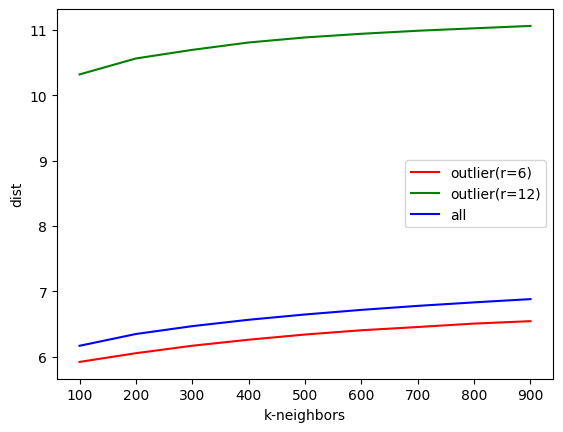

In [193]:
anomaly_12 = res_e.scores[:, 175].argsort()[-10:][::-1]
anomaly_6 = res_e.scores[:, 76].argsort()[-10:][::-1]
fig, ax = plt.subplots()
lines = []

xs = [k for k in range(100, 1000, 100)]

ax.plot(xs, [res_e.sorted_dist[anomaly_6, k].mean() for k in range(100, 1000, 100)], color='r', label="outlier(r=6)")
ax.plot(xs, [res_e.sorted_dist[anomaly_12, k].mean() for k in range(100, 1000, 100)], color='g', label="outlier(r=12)")
ax.plot(xs, [res_e.sorted_dist[:, k].mean() for k in range(100, 1000, 100)], color='b', label="all")
ax.set_xlabel('k-neighbors')
ax.set_ylabel('dist')
ax.legend()
plt.show()

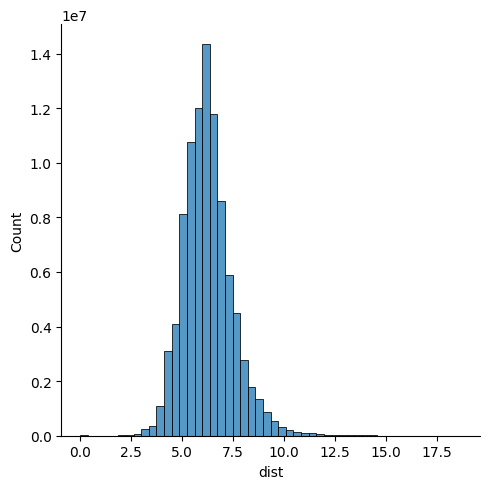

In [24]:
mat0_n = mat0.copy()
dist_original_n = pairwise_distances(X = mat0_n, metric='euclidean')
import seaborn as sns
import pandas as pd
dist_original_n_data = pd.DataFrame({ 'dist': dist_original_n.reshape(-1) })
sns.displot(data=dist_original_n_data, x="dist", bins=50, log_scale=(False, False))
plt.show()

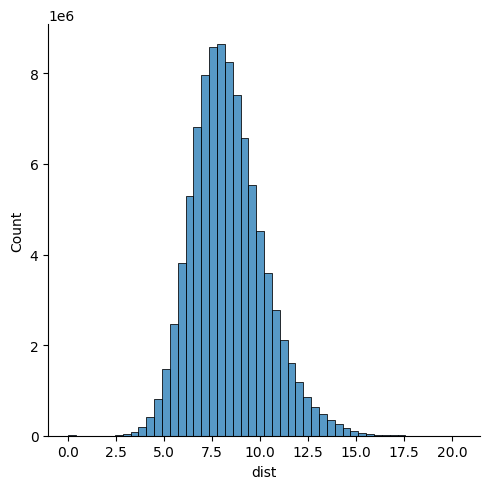

In [25]:
mat_normal = mat.copy()
dist_fuzzy_n = pairwise_distances(X = mat_normal, metric='euclidean')
import seaborn as sns
import pandas as pd
dist_fuzzy_n_data = pd.DataFrame({ 'dist': dist_fuzzy_n.reshape(-1) })
sns.displot(data=dist_fuzzy_n_data, x="dist", bins=50, log_scale=(False, False))
plt.show()

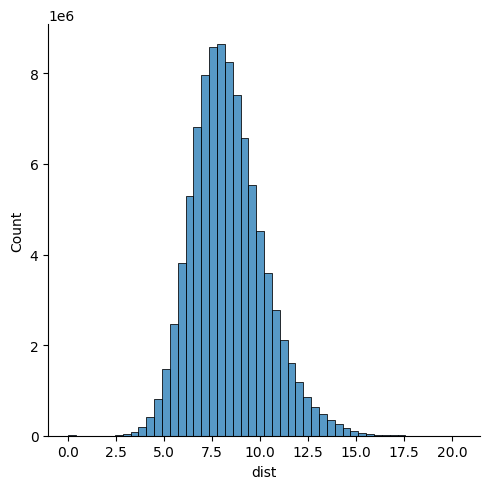

In [56]:
mat_normal = mat.copy()
dist_fuzzy_n = pairwise_distances(X = mat_normal, metric='euclidean')
import seaborn as sns
import pandas as pd
dist_fuzzy_n_data = pd.DataFrame({ 'dist': dist_fuzzy_n.reshape(-1) })
sns.displot(data=dist_fuzzy_n_data, x="dist", bins=50, log_scale=(False, False))
plt.show()

In [79]:
np.flatnonzero(np.array(rese9.rs) > 12)[0]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [73]:
rese5.sorted_dist.mean()

8.348170821922853